In [ ]:
## given and entire unsolved sudoku, what is the value of just one cell? let's say, the first cell. 

In [24]:
import numpy as np 
import pandas as pd
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
import random
import matplotlib.pyplot as plt


def their_data(filename, size):
	DATA_SIZE = size
	quizzes = np.zeros((DATA_SIZE, 81), np.int32)
	solutions = np.zeros((DATA_SIZE, 81), np.int32)
	for i, line in enumerate(open(filename, 'r').read().splitlines()[1:]):
	    quiz, solution = line.split(",")
	    for j, q_s in enumerate(zip(quiz, solution)):
	        q, s = q_s
	        quizzes[i, j] = q
	        solutions[i, j] = s

	quizzes = quizzes.reshape((-1, 9, 9))
	solutions = solutions.reshape((-1, 9, 9))
	return quizzes, solutions



def my_data(filename, size):
	DATA_SIZE = size
	quizzes = np.zeros((DATA_SIZE, 81), np.int32)
	solutions = np.zeros((DATA_SIZE, 81), np.int32)
	for i, line in enumerate(open(filename, 'r').read().splitlines()[1:]):
	    quiz, solution = line.split(",")
	    quiz = quiz[1:-1]
	    solution = solution[2:-1]
	    for j, q_s in enumerate(zip(quiz, solution)):
	        q, s = q_s
	        quizzes[i, j] = q
	        solutions[i, j] = s
	quizzes = quizzes.reshape((-1, 9, 9))
	solutions = solutions.reshape((-1, 9, 9))
	return quizzes, solutions


#qmillion, smillion = my_data("mixedSudokusBetter.csv", 1000000)
q30k, s30k = my_data("30k_mixedSudokus75_80.csv", 30000)
q80, s80 = my_data("s_make80.csv", 5000)
#qbig, sbig = their_data("1mTheirSudokus.csv", 1000000)
#print("Done with trivial files")
q1m, s1m = my_data("mixedSudokus1m.csv", 1000000)
print("Done with file q1")
#q2m, s2m = my_data("mixedSudokus2m.csv", 1000000)
#print("Done with file q2")
#q3m, s3m = my_data("mixedSudokus3m.csv", 1000000)
#print("Done with file q3")
#q4m, s4m = my_data("mixedSudokus4m.csv", 1000000)
#print("Done with file reading")


mega_quiz = np.concatenate((q1m,q80, q30k), axis=0)
mega_sol = np.concatenate((s1m,s80, s30k), axis=0)
print("Done with concatenate")

Done with concatenate


In [25]:
## flatten the solutions: 

def flatten_sols(np_arr):
    one_puzzle = []
    for i in range(0,len(np_arr)):
        one_puzzle.append(np_arr[i].flatten())
    one_puzzle = np.asarray(one_puzzle)
    return one_puzzle

mega_sol = flatten_sols(mega_sol)

print(mega_sol[0])

[4 1 2 3 6 8 9 5 7 6 9 8 1 7 5 3 4 2 3 5 7 4 2 9 1 8 6 5 8 3 7 4 2 6 1 9 9
 7 6 5 3 1 4 2 8 2 4 1 9 8 6 5 7 3 7 2 5 6 1 3 8 9 4 8 3 9 2 5 4 7 6 1 1 6
 4 8 9 7 2 3 5]


In [26]:
#mega_quiz[0]

In [27]:
#mega_sol[0][0][0]

In [28]:
## extract the values of the very first cell of each solution
def extract_values(numpy_arr, cell):
    values_of_cell = []
    for i in range(len(numpy_arr)):
        values_of_cell.append(numpy_arr[i][cell])
    return np.asarray(values_of_cell)


## loop that creates n amount of solution arrays: 
solutions = [] #list of solution arrays

for j in range(0,81):                  ## 9 digit max... need to flatten solutions 
    s = extract_values(mega_sol,j)
    solutions.append(s)

#print(solutions[0][2])
#solutions[0].shape
## solutions is now a list of np arrays, each one representing the nth cell of all given sudoku solutions

#print(mega_quiz[0])
#print(solutions[0][0])
#print(solutions[1][0])


In [29]:
## Shuffle, normalize and add extra dimension to n_qmega because of convolution layers 
SEED = 42
np.random.seed(SEED)
np.random.shuffle(mega_quiz)

## shuffle all sudoku solutions
for i in range(len(solutions)):
    np.random.seed(SEED)
    np.random.shuffle(solutions[i])

print("Done with mega shuffle")

#print(mega_quiz[0])
#print(solutions[0][0])
#print(solutions[1][0])



Done with mega shuffle


In [30]:
solutions = np.asarray(solutions)

In [31]:
solutions[0]

array([4, 2, 9, ..., 9, 4, 2])

In [32]:
solutions.shape

(81, 35000)

In [33]:
## normalize all solutions arrays in solutions list:
solutions = solutions / 9.
    
n_qmega = mega_quiz / 9.

print("Done with normalize")


## add extra dimension: 
n_qmega = np.expand_dims(n_qmega, -1)

print("added dimension")


Done with normalize
added dimension


In [48]:
solutions[5]

array([0.11111111, 0.77777778, 0.11111111, ..., 0.66666667, 0.22222222,
       0.66666667])

In [61]:
i = Input(shape=n_qmega[0].shape)
x = Conv2D(16, (3,3), strides=1, activation='relu',padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), strides=1, activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), strides=1, activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation="relu", bias_initializer="random_uniform")(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="relu", bias_initializer="random_uniform")(x)
x = Dropout(0.2)(x)
x = Dense(81, activation="relu", bias_initializer="random_uniform")(x)
## 1:
c1 = Dense(1, activation="linear", bias_initializer="random_uniform")(x)
c2 = Dense(1, activation="linear", bias_initializer="random_uniform")(x)
c3 = Dense(1, activation="linear", bias_initializer="random_uniform")(x)
c4 = Dense(1, activation="linear", bias_initializer="random_uniform")(x)
c5 = Dense(1, activation="linear", bias_initializer="random_uniform")(x)
c6 = Dense(1, activation="linear", bias_initializer="random_uniform")(x)
c7 = Dense(1, activation="linear", bias_initializer="random_uniform")(x)
c8 = Dense(1, activation="linear", bias_initializer="random_uniform")(x)
c9 = Dense(1, activation="linear", bias_initializer="random_uniform")(x)
## 2:
c10 = Dense(1, activation="linear")(x)
c11 = Dense(1, activation="linear")(x)
c12 = Dense(1, activation="linear")(x)
c13 = Dense(1, activation="linear")(x)
c14 = Dense(1, activation="linear")(x)
c15 = Dense(1, activation="linear")(x)
c16 = Dense(1, activation="linear")(x)
c17 = Dense(1, activation="linear")(x)
c18 = Dense(1, activation="linear")(x)
## 3:
c19 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c20 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c21 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c22 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c23 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c24 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c25 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c26 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c27 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
## 4:
c28 = Dense(1, activation="linear")(x)
c29 = Dense(1, activation="linear")(x)
c30 = Dense(1, activation="linear")(x)
c31 = Dense(1, activation="linear")(x)
c32 = Dense(1, activation="linear")(x)
c33 = Dense(1, activation="linear")(x)
c34 = Dense(1, activation="linear")(x)
c35 = Dense(1, activation="linear")(x)
c36 = Dense(1, activation="linear")(x)
## 5:
c37 = Dense(1, activation="relu")(x)
c38 = Dense(1, activation="relu")(x)
c39 = Dense(1, activation="relu")(x)
c40 = Dense(1, activation="relu")(x)
c41 = Dense(1, activation="relu")(x)
c42 = Dense(1, activation="relu")(x)
c43 = Dense(1, activation="relu")(x)
c44 = Dense(1, activation="relu")(x)
c45 = Dense(1, activation="relu")(x)
## 6:
c46 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c47 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c48 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c49 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c50 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c51 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c52 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c53 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c54 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
## 7:
c55 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c56 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c57 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c58 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c59 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c60 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c61 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c62 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c63 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
## 8:
c64 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c65 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c66 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c67 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c68 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c69 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c70 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c71 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c72 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
## 9:
c73 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c74 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c75 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c76 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c77 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c78 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c79 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c80 = Dense(1, activation="linear", bias_initializer="random_normal")(x)
c81 = Dense(1, activation="linear", bias_initializer="random_normal")(x)


model = Model(i, [c1,c2,c3,c4,c5,c6,c7,c8,c9,
                 c10,c11,c12,c13,c14,c15,c16,c17,c18,
                 c19,c20,c21,c22,c23,c24,c25,c26,c27,
                 c28,c29,c30,c31,c32,c33,c34,c35,c36,
                 c37,c38,c39,c40,c41,c42,c43,c44,c45,
                 c46,c47,c48,c49,c50,c51,c52,c53,c54,
                 c55,c56,c57,c58,c59,c60,c61,c62,c63,
                 c64,c65,c66,c67,c68,c69,c70,c71,c72,
                 c73,c74,c75,c76,c77,c78,c79,c80,c81])

opt = keras.optimizers.Adam(lr=0.01)
opt2 = keras.optimizers.SGD(lr=0.01, nesterov=True)

## compile and fit model: 

model.compile(optimizer = 'adam',
	loss="mse",
	metrics=[])

print(model.summary())

r = model.fit(n_qmega, 
              [solutions[0], solutions[1],solutions[2], solutions[3],solutions[4], solutions[5],solutions[6], solutions[7], solutions[8],
              solutions[9], solutions[10],solutions[11], solutions[12],solutions[13], solutions[14],solutions[15], solutions[16], solutions[17],
              solutions[18], solutions[19],solutions[20], solutions[21],solutions[22], solutions[23],solutions[24], solutions[25], solutions[26],
              solutions[27], solutions[28],solutions[29], solutions[30],solutions[31], solutions[32],solutions[33], solutions[34], solutions[35],
              solutions[36], solutions[37],solutions[38], solutions[39],solutions[40], solutions[41],solutions[42], solutions[43], solutions[44],
              solutions[45], solutions[46],solutions[47], solutions[48],solutions[49], solutions[50],solutions[51], solutions[52], solutions[53],
              solutions[54], solutions[55],solutions[56], solutions[57],solutions[58], solutions[59],solutions[60], solutions[61], solutions[62],
              solutions[63], solutions[64],solutions[65], solutions[66],solutions[67], solutions[68],solutions[69], solutions[70], solutions[71],
              solutions[72], solutions[73],solutions[74], solutions[75],solutions[76], solutions[77],solutions[78], solutions[79], solutions[80]], 
               epochs=20, batch_size=500, validation_split=0.001, verbose=1)
               
               
               

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 9, 9, 1)]    0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 9, 9, 16)     160         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 9, 9, 16)     64          conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 9, 9, 32)     4640        batch_normalization_12[0][0]     
____________________________________________________________________________________________

Train on 34965 samples, validate on 35 samples
Epoch 1/5
34965/34965 [==============================] - 34s 983us/sample - loss: 11.6674 - dense_333_loss: 0.1178 - dense_334_loss: 0.1617 - dense_335_loss: 0.1127 - dense_336_loss: 0.1736 - dense_337_loss: 0.1598 - dense_338_loss: 0.1223 - dense_339_loss: 0.1552 - dense_340_loss: 0.2243 - dense_341_loss: 0.1159 - dense_342_loss: 0.1353 - dense_343_loss: 0.1631 - dense_344_loss: 0.2839 - dense_345_loss: 0.1493 - dense_346_loss: 0.1455 - dense_347_loss: 0.1111 - dense_348_loss: 0.1157 - dense_349_loss: 0.1361 - dense_350_loss: 0.1132 - dense_351_loss: 0.1246 - dense_352_loss: 0.1151 - dense_353_loss: 0.1922 - dense_354_loss: 0.1350 - dense_355_loss: 0.1178 - dense_356_loss: 0.1177 - dense_357_loss: 0.1284 - dense_358_loss: 0.1144 - dense_359_loss: 0.1176 - dense_360_loss: 0.1585 - dense_361_loss: 0.1209 - dense_362_loss: 0.1425 - dense_363_loss: 0.1570 - dense_364_loss: 0.1140 - dense_365_loss: 0.1053 - dense_366_loss: 0.1626 - dense_367_l

Epoch 3/5
34965/34965 [==============================] - 10s 294us/sample - loss: 6.5014 - dense_333_loss: 0.0779 - dense_334_loss: 0.0789 - dense_335_loss: 0.0743 - dense_336_loss: 0.0772 - dense_337_loss: 0.0779 - dense_338_loss: 0.0774 - dense_339_loss: 0.0695 - dense_340_loss: 0.0750 - dense_341_loss: 0.0777 - dense_342_loss: 0.0768 - dense_343_loss: 0.0757 - dense_344_loss: 0.0769 - dense_345_loss: 0.0754 - dense_346_loss: 0.0766 - dense_347_loss: 0.0730 - dense_348_loss: 0.0780 - dense_349_loss: 0.0758 - dense_350_loss: 0.0762 - dense_351_loss: 0.0746 - dense_352_loss: 0.0776 - dense_353_loss: 0.0794 - dense_354_loss: 0.0761 - dense_355_loss: 0.0804 - dense_356_loss: 0.0743 - dense_357_loss: 0.0734 - dense_358_loss: 0.0720 - dense_359_loss: 0.0709 - dense_360_loss: 0.0757 - dense_361_loss: 0.0764 - dense_362_loss: 0.0789 - dense_363_loss: 0.0731 - dense_364_loss: 0.0731 - dense_365_loss: 0.0787 - dense_366_loss: 0.0727 - dense_367_loss: 0.0794 - dense_368_loss: 0.0776 - dense_369

Epoch 5/5
34965/34965 [==============================] - 10s 289us/sample - loss: 5.9181 - dense_333_loss: 0.0693 - dense_334_loss: 0.0699 - dense_335_loss: 0.0644 - dense_336_loss: 0.0682 - dense_337_loss: 0.0703 - dense_338_loss: 0.0684 - dense_339_loss: 0.0662 - dense_340_loss: 0.0679 - dense_341_loss: 0.0661 - dense_342_loss: 0.0701 - dense_343_loss: 0.0703 - dense_344_loss: 0.0725 - dense_345_loss: 0.0674 - dense_346_loss: 0.0703 - dense_347_loss: 0.0669 - dense_348_loss: 0.0713 - dense_349_loss: 0.0680 - dense_350_loss: 0.0708 - dense_351_loss: 0.0685 - dense_352_loss: 0.0701 - dense_353_loss: 0.0712 - dense_354_loss: 0.0686 - dense_355_loss: 0.0717 - dense_356_loss: 0.0649 - dense_357_loss: 0.0640 - dense_358_loss: 0.0660 - dense_359_loss: 0.0652 - dense_360_loss: 0.0713 - dense_361_loss: 0.0706 - dense_362_loss: 0.0739 - dense_363_loss: 0.0646 - dense_364_loss: 0.0643 - dense_365_loss: 0.0698 - dense_366_loss: 0.0669 - dense_367_loss: 0.0719 - dense_368_loss: 0.0697 - dense_369

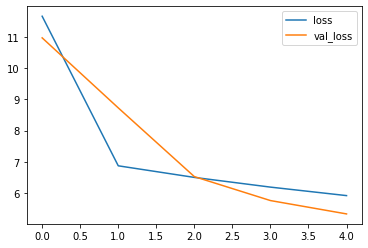

In [62]:
## Plot model loss over time
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [63]:
# Plot model accuracy over time
#plt.plot(r.history['dense_12_accuracy'], label='acc')
#plt.plot(r.history['val_dense_12_accuracy'], label='val_acc')
#plt.legend()

In [64]:
## check multi output solutions:

validation_set_quizzes = n_qmega[0:15000,:,:,:]

p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24,p25,p26,p27,p28,p29,p30,p31,p32,p33,p34,p35,p36,p37,p38,p39,p40,p41,p42,p43,p44,p45,p46,p47,p48,p49,p50,p51,p52,p53,p54,p55,p56,p57,p58,p59,p60,p61,p62,p63,p64,p65,p66,p67,p68,p69,p70,p71,p72,p73,p74,p75,p76,p77,p78,p79,p80,p81 = model.predict(validation_set_quizzes)


# p1 shape = (15000, 1), etc.
# p1 = all sudokus, 1st cell, p2 = all sudokus 2nd cell, etc. 
# so, I need to compare p1 with solutions[0], because solutions[0], is all sudokus' first cell.


In [65]:
solutions.shape

(81, 35000)

In [66]:
## reverse normalize: 
##
p1 = np.round((p1 *9), decimals=0) 
p2 = np.round((p2 *9), decimals=0) 
p3 = np.round((p3 *9), decimals=0) 
p4 = np.round((p4 *9), decimals=0) 
p5 = np.round((p5 *9), decimals=0) 
p6 = np.round((p6 *9), decimals=0) 
p7 = np.round((p7 *9), decimals=0) 
p8 = np.round((p8 *9), decimals=0) 
p9 = np.round((p9 *9), decimals=0) 
##
p10 = np.round((p10 *9), decimals=0) 
p11 = np.round((p11 *9), decimals=0) 
p12 = np.round((p12 *9), decimals=0) 
p13 = np.round((p13 *9), decimals=0) 
p14 = np.round((p14 *9), decimals=0) 
p15 = np.round((p15 *9), decimals=0) 
p16 = np.round((p16 *9), decimals=0) 
p17 = np.round((p17 *9), decimals=0) 
p18 = np.round((p18 *9), decimals=0) 
##
p19 = np.round((p19 *9), decimals=0) 
p20 = np.round((p20 *9), decimals=0) 
p21 = np.round((p21 *9), decimals=0) 
p22 = np.round((p22 *9), decimals=0) 
p23 = np.round((p23 *9), decimals=0) 
p24 = np.round((p24 *9), decimals=0) 
p25 = np.round((p25 *9), decimals=0) 
p26 = np.round((p26 *9), decimals=0) 
p27 = np.round((p27 *9), decimals=0) 
##
p28 = np.round((p28 *9), decimals=0) 
p29 = np.round((p29 *9), decimals=0) 
p30 = np.round((p30 *9), decimals=0) 
p31 = np.round((p31 *9), decimals=0) 
p32 = np.round((p32 *9), decimals=0) 
p33 = np.round((p33 *9), decimals=0) 
p34 = np.round((p34 *9), decimals=0) 
p35 = np.round((p35 *9), decimals=0) 
p36 = np.round((p36 *9), decimals=0) 
##
p37 = np.round((p37 *9), decimals=0) 
p38 = np.round((p38 *9), decimals=0) 
p39 = np.round((p39 *9), decimals=0) 
p40 = np.round((p40 *9), decimals=0) 
p41 = np.round((p41 *9), decimals=0) 
p42 = np.round((p42 *9), decimals=0) 
p43 = np.round((p43 *9), decimals=0) 
p44 = np.round((p44 *9), decimals=0) 
p45 = np.round((p45 *9), decimals=0) 
##
p46 = np.round((p46 *9), decimals=0) 
p47 = np.round((p47 *9), decimals=0) 
p48 = np.round((p48 *9), decimals=0) 
p49 = np.round((p49 *9), decimals=0) 
p50 = np.round((p50 *9), decimals=0) 
p51 = np.round((p51 *9), decimals=0) 
p52 = np.round((p52 *9), decimals=0) 
p53 = np.round((p53 *9), decimals=0) 
p54 = np.round((p54 *9), decimals=0) 
##
p55 = np.round((p55 *9), decimals=0) 
p56 = np.round((p56 *9), decimals=0) 
p57 = np.round((p57 *9), decimals=0) 
p58 = np.round((p58 *9), decimals=0) 
p59 = np.round((p59 *9), decimals=0) 
p60 = np.round((p60 *9), decimals=0) 
p61 = np.round((p61 *9), decimals=0) 
p62 = np.round((p62 *9), decimals=0) 
p63 = np.round((p63 *9), decimals=0) 
##
p64 = np.round((p64 *9), decimals=0) 
p65 = np.round((p65 *9), decimals=0) 
p66 = np.round((p66 *9), decimals=0) 
p67 = np.round((p67 *9), decimals=0) 
p68 = np.round((p68 *9), decimals=0) 
p69 = np.round((p69 *9), decimals=0) 
p70 = np.round((p70 *9), decimals=0) 
p71 = np.round((p71 *9), decimals=0) 
p72 = np.round((p72 *9), decimals=0) 
##
p73 = np.round((p73 *9), decimals=0) 
p74 = np.round((p74 *9), decimals=0) 
p75 = np.round((p75 *9), decimals=0) 
p76 = np.round((p76 *9), decimals=0) 
p77 = np.round((p77 *9), decimals=0) 
p78 = np.round((p78 *9), decimals=0) 
p79 = np.round((p79 *9), decimals=0) 
p80 = np.round((p80 *9), decimals=0) 
p81 = np.round((p81 *9), decimals=0) 

sol = solutions
sol = np.round((sol * 9), decimals=0)


In [67]:
#recreate the original sudoku shape from predictions:
all_predictions = []
for i in range(0, 15000):
    sudoku_prediction = np.array([p1[i][0],p2[i][0],p3[i][0],p4[i][0],p5[i][0],p6[i][0],p7[i][0],p8[i][0],p9[i][0],
                                 p10[i][0],p11[i][0],p12[i][0],p13[i][0],p14[i][0],p15[i][0],p16[i][0],p17[i][0],p18[i][0],
                                 p19[i][0],p20[i][0],p21[i][0],p22[i][0],p23[i][0],p24[i][0],p25[i][0],p26[i][0],p27[i][0],
                                 p28[i][0],p29[i][0],p30[i][0],p31[i][0],p32[i][0],p33[i][0],p34[i][0],p35[i][0],p36[i][0],
                                 p37[i][0],p38[i][0],p39[i][0],p40[i][0],p41[i][0],p42[i][0],p43[i][0],p44[i][0],p45[i][0],
                                 p46[i][0],p47[i][0],p48[i][0],p49[i][0],p50[i][0],p51[i][0],p52[i][0],p53[i][0],p54[i][0],
                                 p55[i][0],p56[i][0],p57[i][0],p58[i][0],p59[i][0],p60[i][0],p61[i][0],p62[i][0],p63[i][0],
                                 p64[i][0],p65[i][0],p66[i][0],p67[i][0],p68[i][0],p69[i][0],p70[i][0],p71[i][0],p72[i][0],
                                 p73[i][0],p74[i][0],p75[i][0],p76[i][0],p77[i][0],p78[i][0],p79[i][0],p80[i][0],p81[i][0]])
    all_predictions.append(sudoku_prediction)
    
all_predictions = np.asarray(all_predictions)

all_reshaped = np.reshape(all_predictions, (-1,9,9))


print(all_reshaped[9])

[[4. 4. 5. 5. 4. 6. 5. 3. 6.]
 [6. 4. 5. 4. 4. 5. 4. 5. 6.]
 [4. 5. 5. 4. 6. 6. 3. 4. 6.]
 [4. 5. 4. 5. 5. 5. 5. 5. 6.]
 [5. 6. 0. 6. 3. 3. 6. 4. 7.]
 [7. 6. 5. 7. 3. 3. 4. 5. 3.]
 [4. 4. 6. 5. 6. 5. 5. 6. 4.]
 [5. 3. 4. 3. 7. 4. 6. 6. 4.]
 [6. 6. 3. 4. 3. 6. 5. 5. 3.]]


Unique Values in Prediction:  [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Occurence Count in Prediction:  [ 15000    157   8745 100658 347715 447321 240029  51611   3679     85]



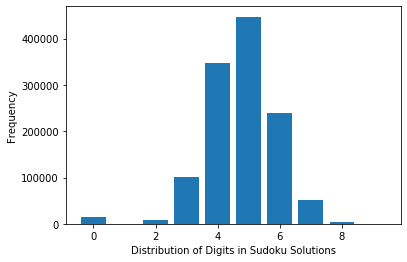

In [73]:
# Check Range of Values in Predictions:
preds = all_reshaped
uniqueValues, occurCount = np.unique(preds, return_counts=True)


print("Unique Values in Prediction: ", uniqueValues)
print("Occurence Count in Prediction: ", occurCount)
print()


## Plot Range of Values in Prediction
histogramP = plt.bar(uniqueValues, occurCount, )
plt.xlabel('Distribution of Digits in Sudoku Solutions')
plt.ylabel('Frequency')
plt.show()

In [69]:
p1_bool = []
p11_bool = []
p21_bool = []
p31_bool = []
p41_bool = []
p51_bool = []
p61_bool = []
p71_bool = []
p81_bool = []


for i in range(0, 15000):
    p1_bool.append(p1[i][0] == sol[0][i])
    p11_bool.append(p11[i][0] == sol[10][i])
    p21_bool.append(p21[i][0] == sol[20][i])
    p31_bool.append(p31[i][0] == sol[30][i])
    p41_bool.append(p41[i][0] == sol[40][i])
    p51_bool.append(p51[i][0] == sol[50][i])
    p61_bool.append(p61[i][0] == sol[60][i])
    p71_bool.append(p71[i][0] == sol[70][i])
    p81_bool.append(p81[i][0] == sol[80][i])


p1_trues = p1_bool.count(True)
p11_trues = p11_bool.count(True)
p21_trues = p21_bool.count(True)
p31_trues = p31_bool.count(True)
p41_trues = p41_bool.count(True)
p51_trues = p51_bool.count(True)
p61_trues = p61_bool.count(True)
p71_trues = p71_bool.count(True)
p81_trues = p81_bool.count(True)


print("p1 has", p1_trues, "correct predictions. ", p1_trues / 150, " percent accurate!" )
print("p11 has", p11_trues, "correct predictions ", p11_trues / 150, " percent accurate!")
print("p21 has", p21_trues, "correct predictions. ", p21_trues / 150, " percent accurate!" )
print("p31 has ", p31_trues, "correct predictions ", p31_trues / 150, " percent accurate!")
print("p41 has", p41_trues, "correct predictions. ", p41_trues / 150, " percent accurate!" )
print("p51 has", p51_trues, "correct predictions ", p51_trues / 150, " percent accurate!")
print("p61 has", p61_trues, "correct predictions. ", p61_trues / 150, " percent accurate!" )
print("p71 has", p71_trues, "correct predictions ", p71_trues / 150, " percent accurate!")
print("p81 has", p81_trues, "correct predictions. ", p81_trues / 150, " percent accurate!" )


p1 has 2084 correct predictions.  13.893333333333333  percent accurate!
p11 has 2032 correct predictions  13.546666666666667  percent accurate!
p21 has 2052 correct predictions.  13.68  percent accurate!
p31 has  2277 correct predictions  15.18  percent accurate!
p41 has 2152 correct predictions.  14.346666666666666  percent accurate!
p51 has 2252 correct predictions  15.013333333333334  percent accurate!
p61 has 1867 correct predictions.  12.446666666666667  percent accurate!
p71 has 2048 correct predictions  13.653333333333334  percent accurate!
p81 has 1949 correct predictions.  12.993333333333334  percent accurate!


In [70]:
## SUDOKU SOLUTION CHECKING LOGIC:
#master functions to check a sudoku:

def isSolved(sudoku):
	return (check_rows(sudoku) and check_cols(sudoku) and check_blocks(sudoku))

def check_rows(arr):
	for l in arr:
		my_list = []
		for i in l:
			my_list.append(i)
		if checkIfDuplicates_1(my_list) or sum(my_list) != 45:
			return False
	return True

def check_cols(arr):
	trans = arr.transpose()
	return check_rows(trans)

def func(arr, h, h2, e, e2):
	my_list = [] 
	for i in range(h, h2):
		for j in range(e, e2):
			my_list.append(arr[i][j])
	if checkIfDuplicates_1(my_list) or sum(my_list) != 45:
		return False
	return True

def check_blocks(arr):
	if(func(arr, 0,3,0,3) and
		func(arr, 0,3,3,6) and
		func(arr, 0,3,6,9) and
		func(arr, 3,6,0,3) and
		func(arr, 3,6,3,6) and
		func(arr, 3,6,6,9) and
		func(arr, 6,9,0,3) and
		func(arr, 6,9,3,6) and
		func(arr, 6,9,6,9)):
		return True
	else:
		return False


def checkIfDuplicates_1(listOfElems):
    if len(listOfElems) == len(set(listOfElems)):
        return False
    else:
        return True


## TRUE ACCURACY CHECK
## Check random set of predictions and whether they are correctly solved sudokus: 

checkLength = 1000
booleanList = []
for i in range(0,checkLength):
	booleanList.append(isSolved(all_reshaped[random.randint(0,14000)]))

trues = booleanList.count(True)
total_accuracy = trues / checkLength * 100

print("#####################################################################")
print()
print("ACCURACY: ")
print("About ", total_accuracy, " percent of predicted solutions are correct")
print(trues, " of ", checkLength, " predicted sudokus were solved correctly")
print()
print("#####################################################################")

#####################################################################

ACCURACY: 
About  0.0  percent of predicted solutions are correct
0  of  1000  predicted sudokus were solved correctly

#####################################################################


In [71]:
## distribution of predicted values: 
#preds = np.round(n_prediction, decimals=0)
#uniqueValues, occurCount = np.unique(preds, return_counts=True)

#print("Unique Values in Prediction: ", uniqueValues)
#print("Occurence Count in Prediction: ", occurCount)
#print()

In [72]:
## Plot Range of Values in Prediction
#histogramP = plt.bar(uniqueValues, occurCount, )
#plt.xlabel('Distribution of Digits in Sudoku Solutions')#plt.ylabel('Frequency')